# Gaussian Mixture Models

This notebook is part of a series of notebooks written in connection with a course in Probabilistic Machine Learning 


The notebook is not selfcontained in the sense that I assume readers are familiar with the concepts

Please see the reference section for 

A Gaussian Mixture Model (GMM) is a sum of $k$ individual Gaussian distributions 

$$
    p(x) = \sum_{k=1}^K \pi_k N(x \vert \mu_k, \Sigma_k)
$$

where $\sum_{k=1}^K \pi_k = 1$. The $\pi_k$'s are called mixing weights.


In [81]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D
from scipy.stats import multivariate_normal, norm

## How to sample from a GMM

Let us define a 2D multivariate Gaussian mixture model with equal mixing weights 1/2.

In [82]:
# Means of the two components
mu1 = np.array([1.0, 1.0])
mu2 = np.array([3.0, 5.0])

# Covariance matrices of the two components
sigma1 = sigma2 = np.eye(2)

# Mixing proportion for the components
weight1 = 0.5
weight2 = 0.5
weights = np.array([weight1, weight2])

and let us draw some samples from this distribution

In [83]:
n_samples = 500

# Sample component indices
component_indices = np.random.choice([0, 1], size=n_samples, p=weights)

# Initialize array to hold samples
samples = np.zeros((n_samples, 2))

gaussian_component_1 = multivariate_normal(mean=mu1, cov=sigma1)
gaussian_component_2 = multivariate_normal(mean=mu2, cov=sigma2)

# Generate samples based on the component indices
samples[component_indices == 0] = gaussian_component_1.rvs(
    size=(component_indices == 0).sum()
)


samples[component_indices == 1] = gaussian_component_2.rvs(
    size=(component_indices == 1).sum()
)

# # Generate samples based on the component indices
# samples[component_indices == 0] = np.random.multivariate_normal(
#     mean=mu1, cov=sigma1, size=(component_indices == 0).sum()
# )

# samples[component_indices == 1] = np.random.multivariate_normal(
#     mu2, sigma2, (component_indices == 1).sum()
# )

### Ancestral Sampling

The sampling approach is known as ancestral sampling since we first sample the weights and afterwards samples from the appropriate Gaussian component. Bishop p 432.

We can plot the samples and densities of the individual components

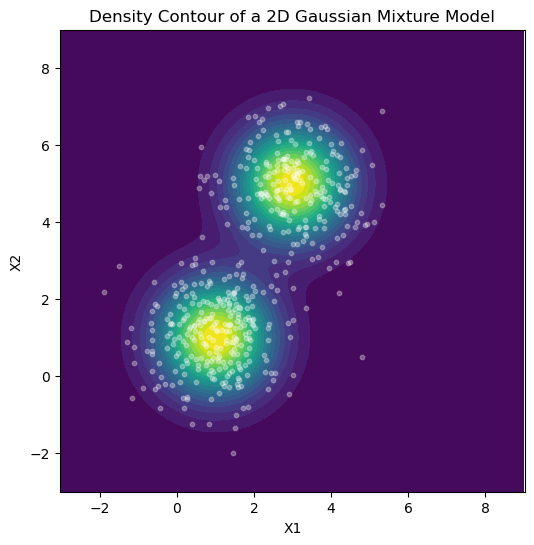

In [84]:
# Define grid for plotting
x, y = np.mgrid[-3:9:0.01, -3:9:0.01]
pos = np.dstack((x, y))

# Compute the density for each component
rv1 = multivariate_normal(mu1, sigma1)
rv2 = multivariate_normal(mu2, sigma2)

# Compute the mixture density
z = weight1 * rv1.pdf(pos) + weight2 * rv2.pdf(pos)

# Plot the contour map and samples
plt.figure(figsize=(6, 6))
plt.contourf(x, y, z, levels=20, cmap="viridis")
plt.scatter(samples[:, 0], samples[:, 1], c="white", s=10, alpha=0.3)
plt.title("Density Contour of a 2D Gaussian Mixture Model")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis("equal")

plt.show()

### Sampling using PyTorch

PyTorch has MixtureSameFamily distribution that we can use to define a GMM and sample directly from it without having to write the sampling code our self.

In [85]:
# Define the mixing weights for the two components (equal weights)
mixing_weights = torch.tensor([0.5, 0.5])

# Create a categorical distribution to represent the mixture weights
mix = D.Categorical(probs=mixing_weights)

# Define the means of the two Gaussian components
means = torch.tensor(
    [
        mu1.tolist(),  # Mean of component 1
        mu2.tolist(),  # Mean of component 2
    ]
)  # Shape: [num_components, num_dimensions]


# Define the covariance matrices of the two Gaussian components
# Here we use identity matrices for simplicity
covariance_matrices = torch.stack(
    [
        torch.eye(2),  # Covariance of component 1
        torch.eye(2),  # Covariance of component 2
    ]
)  # Shape: [num_components, num_dimensions, num_dimensions]

# Create a MultivariateNormal distribution for the components
component_dist = D.MultivariateNormal(loc=means, covariance_matrix=covariance_matrices)

# Combine the categorical and component distributions into a MixtureSameFamily distribution
gmm = D.MixtureSameFamily(mix, component_dist)

# Now you can sample from the GMM
samples = gmm.sample([500])  # Sample 1000 points

In [91]:
samples.shape

torch.Size([500, 2])

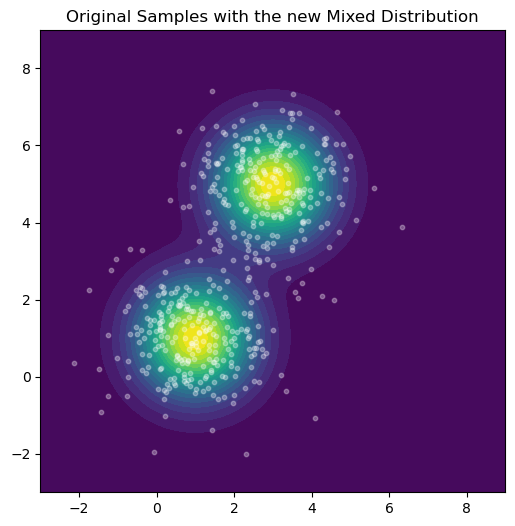

In [86]:
plt.figure(figsize=(6, 6))
plt.contourf(x, y, z, levels=20, cmap="viridis")
plt.scatter(samples[:, 0], samples[:, 1], c="white", s=10, alpha=0.3)
plt.title("Original Samples with the new Mixed Distribution")
plt.show()
plt.close()

## Conditional GMM

If we partition the vector $\mathbf{x}$ into two parts so that $\mathbf{x} = (\mathbf{x}_a, \mathbf{x}_b)$, then the conditional density $p(\mathbf{x}_b \vert \mathbf{x}_a)$ is itself a mixture distribution with weights

$$
  \frac{\pi_k}{\sum_{j=1}^K \pi_j p(\mathbf{x}_a \vert j)}
$$

### Example

Let us see how the conditional distribution for $p(x_2 \vert x_1=2)$ looks like. So we have to compute $PDF(x_1)$ and $PDF(x_2)$ where $PDF$ is the probability density function for the Gaussian components of the previous GMM.

In [87]:
p1 = norm(loc=1, scale=1)

n = 0.5 * p1.cdf(2) + 0.5 * p1.cdf(2)
m = 0.5

m / n

0.5942867086725301

Responsibility matrix

$$
\gamma_{nk} := \frac{\pi_k N(x_n \vert \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j N(x_n \vert \mu_j, \Sigma_j ) } 
$$

Let us try to reproduce the responsibility matrix  in the Mathematics for Machine Learning book  to get some intuition for how it is computed.

Please note that using nested for loops in Python is usually not a good idea as in can be very inefficient. So this implementation is more for illustrative purposes.

In [88]:
K = 3  # Number of components
N = 7  # Number of observations

weights = np.array([1 / 3] * K)  # Equal weights for all components
means = np.array([-4, 0, 8])  # Mean vector
scales = np.array([1, 0.2, 3])  # Standard deviations
variances = scales  # Variances

# Observations
x = np.array([-3, -2.5, -1, 0, 2, 4, 5])

# Initialize the responsibility matrix (N x K)
gamma = np.zeros((N, K))

# Compute the responsibilities
for n in range(N):
    # Compute the Gaussian densities for all components
    p_nk = np.zeros(K)
    for k in range(K):
        p_nk[k] = norm.pdf(x[n], loc=means[k], scale=np.sqrt(variances[k]))

    # Multiply by the weights
    weighted_p_nk = weights * p_nk

    # Compute the responsibilities by normalizing
    total = np.sum(weighted_p_nk)
    gamma[n, :] = weighted_p_nk / total

# Print the responsibility matrix
np.set_printoptions(precision=3, suppress=True)
print("Responsibility Matrix (N x K):")
print(gamma)

Responsibility Matrix (N x K):
[[1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.057 0.943 0.   ]
 [0.    1.    0.   ]
 [0.    0.066 0.934]
 [0.    0.    1.   ]
 [0.    0.    1.   ]]


## Maximum Likelihood Estimator for GMM



$$
\log p(X | \theta) = \sum_{n=1}^N \log p(x_n | \theta) = \sum_{n=1}^N \log \Big( \sum_{k=1}^K \pi_k N(x_n \vert \mu_k, \Sigma_k) \Big)
$$

where $\theta = (\pi, \mu, \Sigma)$. 

From here we usually proceed by taking the derivative of L with respect to $\theta$ but that we not work in this case due to the summation inside the logarithm.

EM algorithm

In [100]:
X = samples.numpy()

In [101]:
# 2. Initialize Parameters
k = 3
n, d = X.shape
np.random.seed(0)
mu = X[np.random.choice(n, k, False), :]
sigma = np.array([np.eye(d) for _ in range(k)])
pi = np.ones(k) / k
gamma = np.zeros((n, k))

# 3. EM Algorithm
tol = 1e-6
max_iter = 100
log_likelihoods = []

for iteration in range(max_iter):
    # E-step
    for i in range(k):
        rv = multivariate_normal(mean=mu[i], cov=sigma[i])
        gamma[:, i] = pi[i] * rv.pdf(X)
    likelihood = np.sum(gamma, axis=1).reshape(-1, 1)
    gamma /= likelihood

    # M-step
    N_k = np.sum(gamma, axis=0)
    for i in range(k):
        mu[i] = np.sum(gamma[:, i].reshape(-1, 1) * X, axis=0) / N_k[i]
        X_centered = X - mu[i]
        sigma[i] = (gamma[:, i].reshape(-1, 1) * X_centered).T @ X_centered / N_k[i]
    pi = N_k / n

    # Log-likelihood
    log_likelihood = np.sum(np.log(likelihood))
    log_likelihoods.append(log_likelihood)

    # Convergence Check
    if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
        break

    print(f"Iteration {iteration + 1}, Log-Likelihood: {log_likelihood:.4f}")

# 4. Visualize Results
cluster_assignments = np.argmax(gamma, axis=1)


Iteration 1, Log-Likelihood: -3151.8202
Iteration 2, Log-Likelihood: -1777.6652
Iteration 3, Log-Likelihood: -1772.2808
Iteration 4, Log-Likelihood: -1770.3866
Iteration 5, Log-Likelihood: -1769.6249
Iteration 6, Log-Likelihood: -1769.2505
Iteration 7, Log-Likelihood: -1769.0146
Iteration 8, Log-Likelihood: -1768.8352
Iteration 9, Log-Likelihood: -1768.6839
Iteration 10, Log-Likelihood: -1768.5503
Iteration 11, Log-Likelihood: -1768.4304
Iteration 12, Log-Likelihood: -1768.3225
Iteration 13, Log-Likelihood: -1768.2256
Iteration 14, Log-Likelihood: -1768.1392
Iteration 15, Log-Likelihood: -1768.0627
Iteration 16, Log-Likelihood: -1767.9953
Iteration 17, Log-Likelihood: -1767.9365
Iteration 18, Log-Likelihood: -1767.8853
Iteration 19, Log-Likelihood: -1767.8411
Iteration 20, Log-Likelihood: -1767.8029
Iteration 21, Log-Likelihood: -1767.7701
Iteration 22, Log-Likelihood: -1767.7418
Iteration 23, Log-Likelihood: -1767.7176
Iteration 24, Log-Likelihood: -1767.6967
Iteration 25, Log-Likelih

In [104]:
class GMM(object):
    def __init__(self, X, k=2):
        # dimension responsibily matrix
        self.n, self.d = X.shape
        # self.data = X.copy()
        # number of mixtures
        self.k = k

        self.mu = X[np.random.choice(self.n, self.k, False), :]
        self.sigma = np.array([np.eye(self.d) for _ in range(self.k)])
        self.pi = np.ones(self.k) / self.k
        self.gamma = np.zeros((self.n, self.k))

        self.tol = 1e-6
        self.max_iter = 100
        self.log_likelihood = 0
        self.log_likelihoods = []

    def e_step(self):
        for i in range(self.k):
            rv = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
            self.gamma[:, i] = self.pi[i] * rv.pdf(X)
        self.likelihood = np.sum(self.gamma, axis=1).reshape(-1, 1)
        self.gamma /= self.likelihood
        # assert self.w[i, :].sum() - 1 < 1e-4

    def m_step(self):
        N_k = np.sum(self.gamma, axis=0)
        for i in range(self.k):
            mu[i] = np.sum(self.gamma[:, i].reshape(-1, 1) * X, axis=0) / N_k[i]
            X_centered = X - self.mu[i]
            self.sigma[i] = (
                (self.gamma[:, i].reshape(-1, 1) * X_centered).T @ X_centered / N_k[i]
            )
        self.pi = N_k / n

    def log_likelihood(self):
        log_likelihood = np.sum(np.log(self.likelihood))
        self.log_likelihoods.append(log_likelihood)

    def fit(self):
        for iteration in range(self.max_iter):
            self.e_step()
            self.m_step()
            self.log_likelihood()
            if (
                iteration > 0
                and abs(self.log_likelihoods[-1] - self.log_likelihoods[-2]) < self.tol
            ):
                break

            print(f"Iteration {iteration + 1}, Log-Likelihood: {log_likelihood:.4f}")

        # cluster assignments
        return np.argmax(gamma, axis=1)


In [105]:
gmm = GMM(X, 2)
res = gmm.fit()

TypeError: 'int' object is not callable

scipy


## References